In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import datetime


In [2]:
# All Defined funstions

def trim_all_columns(df):
# Trim whitespace from ends of each value across all series in dataframe    
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)



def clip_outliers(df ,List, std_coeff=3 ):
    for c in List:
        if ( ( df[c].dtypes == 'int64' )  |  ( df[c].dtypes == 'float' ) ):
            L=df[c].mean()-std_coeff*df[c].std()
            U=df[c].mean()+std_coeff*df[c].std()
            df[c]=df[c].clip(L, U) #, inplace= True, axis= 1)
    return df



In [3]:

df_cust=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_customer.csv',sep=';') 
df_accounts=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_accounts.csv',sep=';')

df_checking_acct=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_checking_acct.csv',sep=';')
df_saving_acct=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_savings_acct.csv',sep=';')
df_credit_acct=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_credit_acct.csv',sep=';')

df_transactions=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_transactions.csv',sep=';')
df_checking_tran=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_checking_tran.csv',sep=';')
df_saving_tran=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_savings_tran.csv',sep=';')
df_credit_tran=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_credit_tran.csv',sep=';')


df_cust =trim_all_columns( df_cust ) 
df_accounts =trim_all_columns( df_accounts ) 

df_checking_acct =trim_all_columns( df_checking_acct ) 
df_saving_acct   =trim_all_columns( df_saving_acct )
df_credit_acct   =trim_all_columns( df_credit_acct )

df_transactions  =trim_all_columns( df_transactions )
df_checking_tran =trim_all_columns( df_checking_tran )
df_saving_tran   =trim_all_columns( df_saving_tran )
df_credit_tran   =trim_all_columns( df_credit_tran )

df_transactions.tran_date=pd.to_datetime(df_transactions.tran_date)
df_checking_tran.tran_date=pd.to_datetime(df_checking_tran.tran_date)
df_saving_tran.tran_date=pd.to_datetime(df_saving_tran.tran_date)
df_credit_tran.tran_date=pd.to_datetime(df_credit_tran.tran_date)



#df_accounts.head(20)b
#df_accounts.info()
#df_accounts['cust_id'].value_counts()
#df_cust['cust_id'].value_counts()
#df_cust.shape
#df_accounts.shape
df_checking_tran.head()

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,1363481,26,-0.15,-0.15,0.0,58.99,1995-01-29,,,FK
1,1362784,90,-200.00,-200.00,0.0,1380.69,1995-02-07,53313,A,WD
2,1363088,46,0.00,0.00,0.0,128.35,1995-03-26,834,A,IQ
3,1363306,32,-40.32,-40.32,0.0,433.06,1995-01-29,,P,WD
4,1363251,11,-87.88,-87.88,0.0,1919.55,1995-08-02,,P,WD


In [4]:
df_checking_tran['acct_type'] = 'CK'
df_saving_tran['acct_type']   = 'SV'
df_credit_tran['acct_type']   = 'CC'

df_trans_all=df_checking_tran.append([df_saving_tran,df_credit_tran])
df_trans_all.head()
#df_trans_all.info

df_trans_all_1 = df_trans_all.copy()
df_trans_all_1 = df_trans_all_1.drop('acct_type', axis=1)
df_trans_all_1 = df_trans_all_1.drop('cust_id', axis=1)

df_trans_all_2 = df_transactions.copy()
df_trans_all_2 = df_trans_all_2.drop('acct_nbr', axis=1)

#df_trans_all_1.compare(df_trans_all_2)





In [5]:
df_checking_acct.head()


#df_checking_tran.head()

#a=df_checking_tran.groupby('cust_id').agg({'tran_date':np.max})
#print( datetime.datetime(1996, 1, 1)-a)






,cust_id,acct_nbr,minimum_balance,per_check_fee,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,1362548,13625482,3000,0.00,Y,11.11.1986,NaN,6004.34,569.65
1,1362487,13624872,3000,0.00,Y,12.1.1995,NaN,2781.07,1401.21
2,1363017,13630172,3000,0.00,Y,19.3.1994,NaN,2694.91,147.15
3,1362752,13627522,100,0.15,Y,8.1.1994,NaN,487.69,3.76
4,1363282,13632822,100,0.15,Y,5.3.1988,NaN,133.90,84.18


In [6]:
# Add Other info from other tables to df_acct_tran

df_acct_tran=df_accounts.copy()

df_acct_tran['years_with_bank'] = 0
df_acct_tran['num_dp'] = 0
df_acct_tran['num_wd'] = 0
df_acct_tran['tran_dp'] = 0
df_acct_tran['tran_wd'] = 0
df_acct_tran['ave_dp'] = 0
df_acct_tran['ave_wd'] = 0
df_acct_tran['recency'] = ''



for i in range(len(df_acct_tran.index)):
    Lookfor_cust_id   = df_acct_tran.cust_id[i]
    Lookfor_acct_type = df_acct_tran.acct_type[i]
    #Lookfor_acc_nbr = df_acct_tran.acct_nbr[i]
    
    # Add years_with_bank from df_cust to df_acct_tran
    df_acct_tran.years_with_bank[i] = df_cust[ df_cust.cust_id == Lookfor_cust_id ].years_with_bank
    
    # CK: Add Number of transactions,summation of Positive transactions, summation of Negative transactions
    if Lookfor_acct_type.strip() == 'CK':
        df_acct_tran.num_dp[i] = df_checking_tran.cust_id.loc[(df_checking_tran.cust_id == Lookfor_cust_id)  &
                                                             (df_checking_tran.tran_amt > 0)               ].count()  
        
        df_acct_tran.num_wd[i] = df_checking_tran.cust_id.loc[(df_checking_tran.cust_id == Lookfor_cust_id)  &
                                                             (df_checking_tran.tran_amt < 0)               ].count()          
        
        df_acct_tran.tran_dp[i]  = df_checking_tran.tran_amt.loc[(df_checking_tran.cust_id == Lookfor_cust_id) & 
                                                                  (df_checking_tran.tran_amt > 0)].sum()  
        
        df_acct_tran.tran_wd[i]  =-df_checking_tran.tran_amt.loc[(df_checking_tran.cust_id == Lookfor_cust_id) & 
                                                                  (df_checking_tran.tran_amt < 0)].sum()  
        
        df_acct_tran.ave_dp[i]= df_acct_tran.tran_dp[i] / df_acct_tran.num_dp[i]
        
        df_acct_tran.ave_wd[i]= df_acct_tran.tran_wd[i] / df_acct_tran.num_wd[i]

        df_acct_tran.recency[i]  = (datetime.datetime(1996, 1, 1)-
                                   (df_checking_tran.tran_date.loc[(df_checking_tran.cust_id == Lookfor_cust_id)].max()))/np.timedelta64(1,'D')
        
        

    # SV: Add Number of transactions,summation of Positive transactions, summation of Negative transactions
    if Lookfor_acct_type.strip() == 'SV':
        df_acct_tran.num_dp[i] = df_saving_tran.cust_id.loc[(df_saving_tran.cust_id == Lookfor_cust_id)  &
                                                             (df_saving_tran.tran_amt > 0)               ].count()  
        
        df_acct_tran.num_wd[i] = df_saving_tran.cust_id.loc[(df_saving_tran.cust_id == Lookfor_cust_id)  &
                                                             (df_saving_tran.tran_amt < 0)               ].count()          
        
        df_acct_tran.tran_dp[i]  = df_saving_tran.tran_amt.loc[(df_saving_tran.cust_id == Lookfor_cust_id) & 
                                                                  (df_saving_tran.tran_amt > 0)].sum()  
        
        df_acct_tran.tran_wd[i]  =-df_saving_tran.tran_amt.loc[(df_saving_tran.cust_id == Lookfor_cust_id) & 
                                                                  (df_saving_tran.tran_amt < 0)].sum()  
        
        df_acct_tran.ave_dp[i]= df_acct_tran.tran_dp[i] / df_acct_tran.num_dp[i]
        
        df_acct_tran.ave_wd[i]= df_acct_tran.tran_wd[i] / df_acct_tran.num_wd[i]        

        df_acct_tran.recency[i]  = (datetime.datetime(1996, 1, 1)-
                                   (df_saving_tran.tran_date.loc[(df_saving_tran.cust_id == Lookfor_cust_id)].max()))/np.timedelta64(1,'D')

        
    # CC: Add Number of transactions,summation of Positive transactions, summation of Negative transactions
    if Lookfor_acct_type.strip() == 'CC':
        df_acct_tran.num_dp[i] = df_credit_tran.cust_id.loc[(df_credit_tran.cust_id == Lookfor_cust_id)  &
                                                             (df_credit_tran.tran_amt > 0)               ].count()  
        
        df_acct_tran.num_wd[i] = df_credit_tran.cust_id.loc[(df_credit_tran.cust_id == Lookfor_cust_id)  &
                                                             (df_credit_tran.tran_amt < 0)               ].count()          
        
        df_acct_tran.tran_dp[i]  = df_credit_tran.tran_amt.loc[(df_credit_tran.cust_id == Lookfor_cust_id) & 
                                                                  (df_credit_tran.tran_amt > 0)].sum()  
        
        df_acct_tran.tran_wd[i]  =-df_credit_tran.tran_amt.loc[(df_credit_tran.cust_id == Lookfor_cust_id) & 
                                                                  (df_credit_tran.tran_amt < 0)].sum()  
        
        df_acct_tran.ave_dp[i]= df_acct_tran.tran_dp[i] / df_acct_tran.num_dp[i]
        
        df_acct_tran.ave_wd[i]= df_acct_tran.tran_wd[i] / df_acct_tran.num_wd[i]
        
        df_acct_tran.recency[i]  = (datetime.datetime(1996, 1, 1)-
                                   (df_credit_tran.tran_date.loc[(df_credit_tran.cust_id == Lookfor_cust_id)].max()))/np.timedelta64(1,'D')
        


df_acct_tran.head(26)   

,acct_nbr,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance,years_with_bank,num_dp,num_wd,tran_dp,tran_wd,ave_dp,ave_wd,recency
0,13628063,1362806,SV,Y,10.12.1995,NaN,1430.22,284.58,3,19,16,1611.39,2757.03,84.810000,172.314375,1.0
1,4561143213627090,1362709,CC,Y,15.3.1993,NaN,266.34,496.15,4,12,40,4280.64,4506.70,356.720000,112.667500,10.0
2,4561143213628360,1362836,CC,Y,18.3.1992,NaN,55.90,1000.00,6,12,24,1122.86,1937.27,93.571667,80.719583,8.0
3,13633112,1363311,CK,Y,6.7.1995,NaN,11017.13,968.46,0,21,59,5978.89,16027.56,284.709048,271.653559,23.0
4,4561143213633610,1363361,CC,Y,17.6.1994,NaN,849.37,462.28,4,11,32,5201.82,4802.77,472.892727,150.086562,1.0
5,4561143213631020,1363102,CC,Y,30.11.1995,NaN,0.00,1000.00,3,1,9,55.95,1055.95,55.950000,117.327778,6.0
6,4561143213633270,1363327,CC,Y,2.4.1995,NaN,0.00,3000.00,0,8,36,1067.48,3947.07,133.435000,109.640833,6.0
7,13628972,1362897,CK,Y,1.8.1995,NaN,152.12,52.33,2,14,64,2743.55,2843.34,195.967857,44.427188,24.0
8,4561143213632370,1363237,CC,N,24.1.1993,30.1.1995,8649.37,0.00,5,1,0,8735.14,-0.00,8735.140000,NaN,336.0
9,13627202,1362720,CK,Y,14.11.1995,NaN,1074.16,216.74,4,13,72,2632.01,3489.43,202.462308,48.464306,45.0


In [7]:
# Deleting redundunt columns 
df_acct_tran_clus=df_acct_tran.copy()

mask1=df_acct_tran_clus['acct_type']=='CK' #CK
mask2=df_acct_tran_clus['acct_type']=='CC' #CC
mask3=df_acct_tran_clus['acct_type']=='SV' #SV

df_acct_tran_clus.loc[mask1,'acct_type']=1  #CK
df_acct_tran_clus.loc[mask2,'acct_type']=2  #CC
df_acct_tran_clus.loc[mask3,'acct_type']=3  #SV

mask4=df_acct_tran_clus['account_active']=='Y' #Active
mask5=df_acct_tran_clus['account_active']=='N' #Inactive

df_acct_tran_clus.loc[mask4,'account_active']=1  #Active
df_acct_tran_clus.loc[mask5,'account_active']=0  #Inactive

df_acct_tran_clus['acct_type'     ] = pd.to_numeric(df_acct_tran_clus['acct_type'     ])
df_acct_tran_clus['account_active'] = pd.to_numeric(df_acct_tran_clus['account_active'])
df_acct_tran_clus['recency'       ] = pd.to_numeric(df_acct_tran_clus['recency'       ])

#df_acct_tran_clus.head()
df_acct_tran_clus.describe()

,acct_nbr,cust_id,acct_type,account_active,starting_balance,ending_balance,years_with_bank,num_dp,num_wd,tran_dp,tran_wd,ave_dp,ave_wd,recency
count,1.409000e+03,1.409000e+03,1409.000000,1409.000000,1409.00000,1409.000000,1409.00000,1409.000000,1409.000000,1409.000000,1409.000000,1387.000000,1295.000000,1397.000000
mean,1.514986e+15,1.362989e+06,1.929737,0.898510,1435.35357,1011.754336,3.84599,14.391057,32.928318,3630.810646,4063.678772,312.004632,133.723088,22.477452
std,2.148991e+15,2.940584e+02,0.814484,0.302084,2186.69662,1559.986310,2.68936,6.106391,25.520293,3812.392741,4354.758379,454.634493,92.163594,40.630812
min,1.362480e+07,1.362480e+06,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,-0.000000,0.150000,0.750000,1.000000
25%,1.362852e+07,1.362727e+06,1.000000,1.000000,189.23000,140.000000,2.00000,12.000000,9.000000,1082.610000,1098.000000,83.863949,77.697703,1.000000
50%,1.363252e+07,1.362985e+06,2.000000,1.000000,487.69000,553.610000,4.00000,14.000000,27.000000,2717.510000,3000.000000,190.677619,112.911020,10.000000
75%,4.561143e+15,1.363251e+06,3.000000,1.000000,2178.79000,1188.570000,6.00000,18.000000,59.000000,4766.130000,5642.840000,383.640833,156.016607,29.000000
max,4.561143e+15,1.363495e+06,3.000000,1.000000,27072.38000,22432.780000,9.00000,34.000000,136.000000,35772.310000,38331.570000,8735.140000,921.365000,336.000000


In [8]:
# Outlier Detection
df_acct_tran_clus_1=clip_outliers(df_acct_tran_clus,['ending_balance','ave_dp','ave_wd','tran_dp','tran_wd','years_with_bank','recency'], std_coeff=3 )
df_acct_tran_clus_1.describe()


,acct_nbr,cust_id,acct_type,account_active,starting_balance,ending_balance,years_with_bank,num_dp,num_wd,tran_dp,tran_wd,ave_dp,ave_wd,recency
count,1.409000e+03,1.409000e+03,1409.000000,1409.000000,1409.00000,1409.000000,1409.00000,1409.000000,1409.000000,1409.000000,1409.000000,1387.000000,1295.000000,1397.000000
mean,1.514986e+15,1.362989e+06,1.929737,0.898510,1435.35357,950.285845,3.84599,14.391057,32.928318,3515.973455,3942.825830,296.021488,131.628800,20.335838
std,2.148991e+15,2.940584e+02,0.814484,0.302084,2186.69662,1184.077416,2.68936,6.106391,25.520293,3273.317465,3772.161686,331.754208,82.954164,29.499224
min,1.362480e+07,1.362480e+06,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,-0.000000,0.150000,0.750000,1.000000
25%,1.362852e+07,1.362727e+06,1.000000,1.000000,189.23000,140.000000,2.00000,12.000000,9.000000,1082.610000,1098.000000,83.863949,77.697703,1.000000
50%,1.363252e+07,1.362985e+06,2.000000,1.000000,487.69000,553.610000,4.00000,14.000000,27.000000,2717.510000,3000.000000,190.677619,112.911020,10.000000
75%,4.561143e+15,1.363251e+06,3.000000,1.000000,2178.79000,1188.570000,6.00000,18.000000,59.000000,4766.130000,5642.840000,383.640833,156.016607,29.000000
max,4.561143e+15,1.363495e+06,3.000000,1.000000,27072.38000,5691.713267,9.00000,34.000000,136.000000,15067.988869,17127.953910,1675.908111,410.213869,144.369886


# Clustering

range(2, 12) [287.39651839139617, 204.2965346644775, 173.00587964677484, 156.28488219415337, 143.50754299950407, 131.9790282475325, 122.56176236936355, 116.24596906738876, 108.89439002612953, 103.04719380979351]


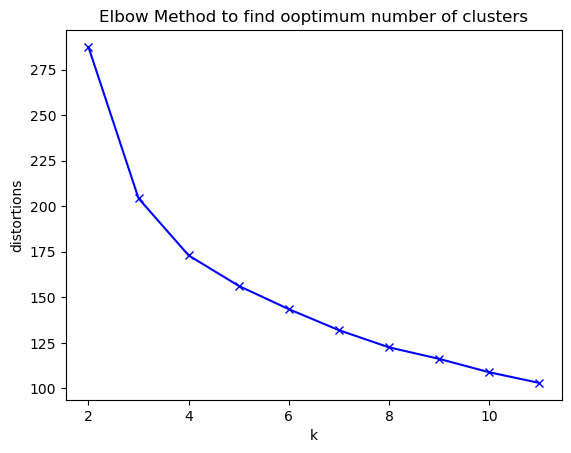

In [9]:
# Clustering




#X=df_acct_tran_clus.drop(['acct_nbr','cust_id','acct_start_date','acct_end_date','starting_balance','account_active','num_dp','num_wd','tran_dp','tran_wd'],axis=1)
#X=df_acct_tran_clus.drop(['acct_nbr','cust_id','acct_start_date','acct_end_date','starting_balance','account_active','tran_dp','tran_wd'],axis=1)

X=df_acct_tran_clus_1.drop(['acct_nbr','cust_id','acct_start_date','years_with_bank','acct_end_date','starting_balance','account_active','tran_dp','tran_wd'],axis=1)



X.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)




MMS=MinMaxScaler()
Xnorm=MMS.fit_transform(X)
kmean_model=KMeans(random_state=2023,n_clusters=3,max_iter=300)
kmean_model.fit(Xnorm)


# Elbow Method to find ooptimum number of clusters

distortions=[]
K=range(2,12)

for k in K:
    model=KMeans(n_clusters=k)
    model.fit(Xnorm)
    distortions.append(model.inertia_)

print(K,distortions)
    
plt.plot(K,distortions,'bx-')
plt.xlabel('k')
plt.ylabel('distortions')
plt.title('Elbow Method to find ooptimum number of clusters')
plt.show()

In [10]:
L=kmean_model.labels_
L


array([1, 2, 2, ..., 2, 1, 0])

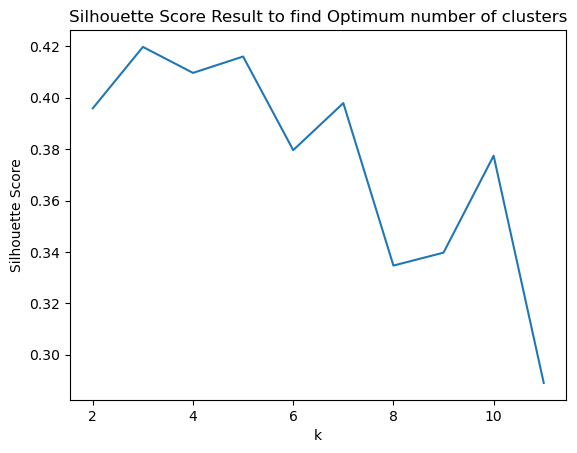

In [11]:
# Silhouette Score Calculations

sil=[]
K=range(2,12)

for k in K:
    model=KMeans(n_clusters=k,random_state=2023)
    model.fit(Xnorm)
    L=model.labels_
    sil.append(silhouette_score(Xnorm,L))

plt.plot(K,sil)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Result to find Optimum number of clusters')
plt.show()


# PCA

In [12]:
pca_model=PCA(n_components=2)
pca_model.fit(Xnorm)
X_pca=pca_model.transform(Xnorm)
X_pca=pd.DataFrame(X_pca,columns=['PC1','PC2'])
X_pca.head()

,PC1,PC2
0,0.592666,-0.152513
1,0.036685,-0.037449
2,0.094645,-0.143695
3,-0.404286,0.203370
4,0.071004,0.054907


In [13]:
pca_model.explained_variance_ratio_

array([0.51824456, 0.18585673])

Text(0, 0.5, '% Cumulative explained variance')

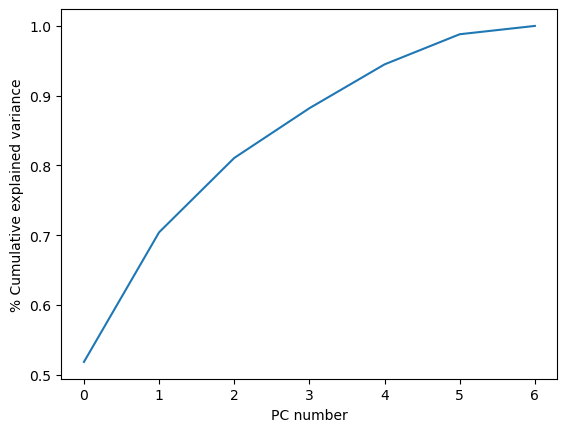

In [14]:
# Create cumulative explained variance graph
# Pretend we'd like to have about 90% explained variance
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(Xnorm)

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_variance)
plt.xlabel('PC number')
plt.ylabel('% Cumulative explained variance')

Stored 'pca_data' (DataFrame)


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

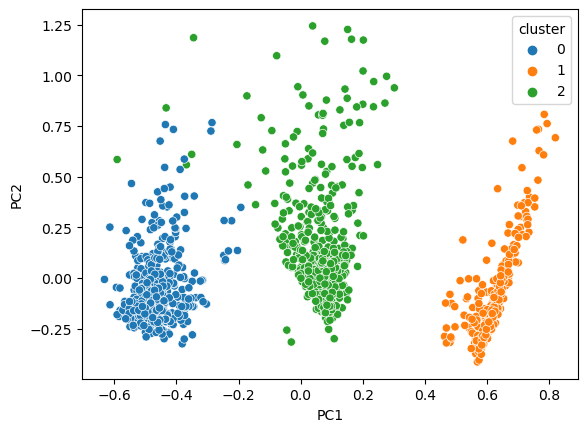

In [23]:
pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(Xnorm),columns=['PC1','PC2']) 
%store pca_data
kmeans =KMeans(n_clusters=3 ,random_state=2023).fit(Xnorm)
pca_data['cluster'] = pd.Categorical(kmeans.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data)

# Radar Chart

In [111]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

X=df_acct_tran_clus_1.drop(['acct_nbr','cust_id','acct_start_date','years_with_bank','acct_end_date','starting_balance','account_active','tran_dp','tran_wd'],axis=1)
X.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)


data=X
pipe = make_pipeline(StandardScaler(),
                           KMeans(init="k-means++", n_clusters=3, 
                                  n_init=4, random_state=0)    )

data['cluster'] = pipe.fit_predict(data)
result = data.groupby(['cluster']).mean()


In [112]:
import textwrap

class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable

    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted

    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True):
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], polar=True, label = "axes{}".format(i)) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=False)
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, labels=gridlabel, angle=angles[j])
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid()
        self.ax.xaxis.grid()

        # Draw outer circle
        self.ax.spines['polar'].set_visible(True)
        
        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, 15, 
                                          break_long_words=False)) for l in labels]
        self.ax.set_xticklabels(labels)
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            if a == 0:
                t.set_ha('center')
            elif a > 0 and a < 180:
                t.set_ha('left')
            elif a == 180:
                t.set_ha('center')
            else:
                t.set_ha('right')

        self.ax.tick_params(axis='both', pad=15)


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)

In [113]:
X

,acct_type,ending_balance,num_dp,num_wd,ave_dp,ave_wd,recency,cluster
0,3,284.58,19,16,84.810000,172.314375,1.0,0
1,2,496.15,12,40,356.720000,112.667500,10.0,0
2,2,1000.00,12,24,93.571667,80.719583,8.0,0
3,1,968.46,21,59,284.709048,271.653559,23.0,1
4,2,462.28,11,32,472.892727,150.086562,1.0,0
...,...,...,...,...,...,...,...,...
1404,2,20.00,8,26,986.718750,241.581154,29.0,2
1405,2,1400.00,12,37,428.359167,157.801351,10.0,0
1406,2,3000.00,12,24,221.575000,102.835833,5.0,0
1407,3,622.46,15,5,35.144000,137.846000,1.0,0


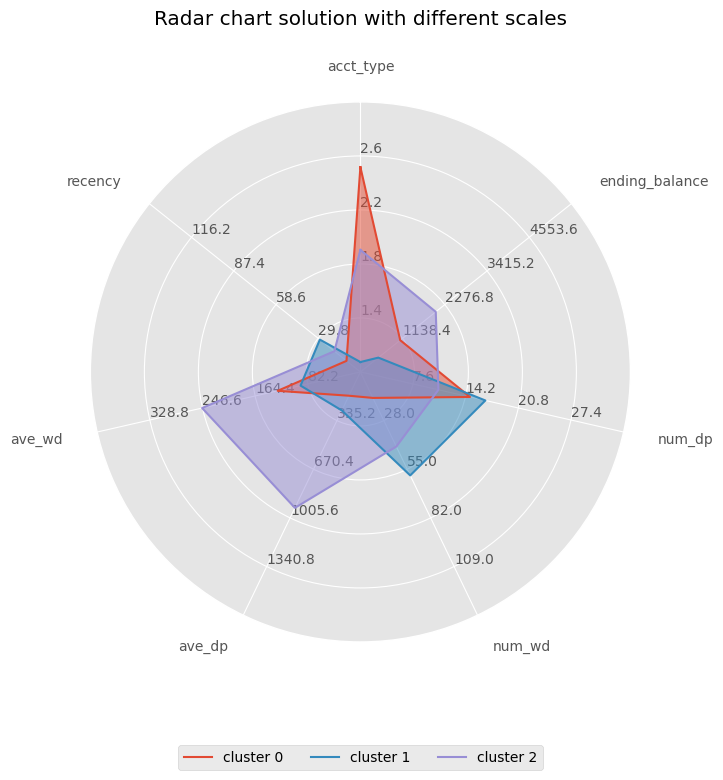

In [114]:
import math

min_max_per_variable = X.describe().T[['min', 'max']]
min_max_per_variable['min'] = min_max_per_variable['min'].apply(lambda x: int(x))
min_max_per_variable['max'] = min_max_per_variable['max'].apply(lambda x: math.ceil(x))

variables = result.columns
ranges = list(min_max_per_variable.itertuples(index=False, name=None))   

fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges, show_scales=True)

for g in result.index:
    radar.plot(result.loc[g].values, label=f"cluster {g}")
    radar.fill(result.loc[g].values, alpha=0.5)

radar.set_title("Radar chart solution with different scales")
radar.use_legend(loc='lower left', bbox_to_anchor=(0.15, -0.25),ncol=radar.plot_counter)
plt.show() 